In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import impute
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import lightgbm as lgbm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, recall_score
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
import re

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Data Cleaning

In [3]:
## fill nan value to median

In [4]:
imp_median = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [5]:
num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()
for num_col in num_cols:
    if train[num_col].isnull().values.any():
        print('imputing for {}'.format(num_col))
        train[num_col] = imp_median.fit_transform(train[num_col].values.reshape(-1,1)) 

imputing for Age


In [6]:
train['Cabin'].fillna('None', inplace = True)

## Feature Engineering

In [7]:
def add_feature(df):
    #ticket length
    df['ticket_len'] = df['Ticket'].str.count(r'[a-zA-Z0-9 ]')
    
    #name honor
    df['Name_honor'] = [re.findall(r'[\w]+\.', item)[0] for item in df.Name.values.tolist()] 
    
    #ticket category
    ticket_name = [item[0] for item in df.Ticket.str.split().tolist()] 
    ticket_name = [re.sub(r'\.', '', item) for item in ticket_name] 
    df['Ticket_cat'] = [item if re.findall(r'^[a-zA-Z]', item) else 'None' for item in ticket_name]
    
    #cabin count
    df['Cabin_count'] = [0 if type(item) == float else len(item) for item in df.Cabin.str.split(' ').values.tolist() ]
    
    #cabin category
    df['Cabin_category'] = ['None' if type(item) == float else list(set(re.findall(r'[a-zA-Z]', item)))[0] 
                           for item in df.Cabin.values.tolist()]
    
    #cabin number
    df['Cabin_number'] = [0 if type(item) == float else 
                             np.mean([int(num) for num in re.findall(r'[\d]+', item)]) 
                             for item in df.Cabin.values.tolist()]
    df['Cabin_number'].fillna(0, inplace = True)
    
    return df

In [8]:
train = add_feature(train)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Feature Scale

In [9]:
obj_cols = train.select_dtypes(include='object').columns.tolist()
num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()

In [10]:
def skewness_check(df, num_cols):
    skew_cols = df[num_cols].skew().sort_values(ascending = False)
    skew_cols = skew_cols[abs(skew_cols) > 2].index.values.tolist()
    return skew_cols

In [11]:
skew_cols = skewness_check(train, num_cols)

### Log Transform

In [12]:
def log_transform(df, column):
    return np.log(df[column] + 1)

In [13]:
train_processed = train.copy()
for skew_col in skew_cols:
    train_processed[skew_col] = log_transform(train_processed, skew_col)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e0922b0>,
      dtype=object)

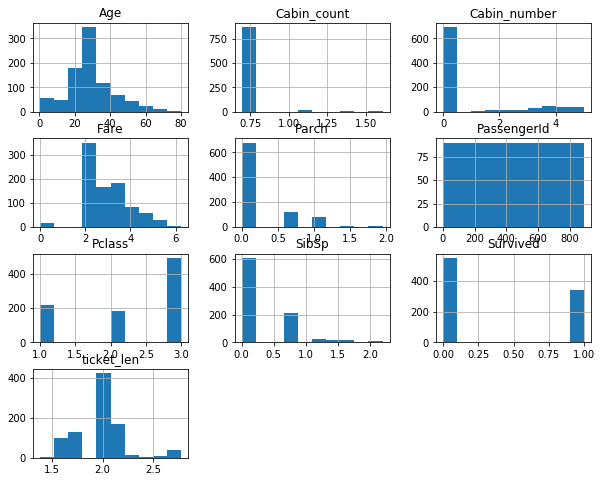

In [14]:
train_processed.hist(figsize=(10,8))

## Train-Test Split and Feature Separation

In [16]:
cols_to_exclude = ['PassengerId','Survived','Ticket','Name','Cabin']

In [17]:
feat_cols = [x for x in train.columns.values.tolist() if x not in cols_to_exclude]

In [18]:
features = pd.get_dummies(train_processed[feat_cols])

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(features, train['Survived'], test_size=0.2, random_state=42)

### Feature Importances

In [20]:
scale_pos_weight_val = train_processed['Survived'].value_counts()[0]//train_processed['Survived'].value_counts()[1]

In [21]:
model = lgbm.LGBMClassifier(objective ='binary',
    learning_rate = 0.01,
    num_leaves = 76,
    n_estimators = 1000,
    feature_fraction= 0.64, 
    bagging_fraction= 0.8, 
    bagging_freq=1,
    boosting_type = 'gbdt',
    metric= 'binary_logloss',
    scale_pos_weight = scale_pos_weight_val,
    silent = True,
    n_jobs = -1)

In [22]:
model.fit(X_train, y_train, 
          eval_metric = ['auc', 'binary_logloss'],
          eval_set = [(X_valid, y_valid)],
          early_stopping_rounds = 500, 
          verbose = True)

[1]	valid_0's auc: 0.867053	valid_0's binary_logloss: 0.676135
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.863127	valid_0's binary_logloss: 0.671507
[3]	valid_0's auc: 0.869241	valid_0's binary_logloss: 0.667033
[4]	valid_0's auc: 0.868919	valid_0's binary_logloss: 0.66306
[5]	valid_0's auc: 0.86686	valid_0's binary_logloss: 0.659024
[6]	valid_0's auc: 0.870013	valid_0's binary_logloss: 0.655249
[7]	valid_0's auc: 0.86879	valid_0's binary_logloss: 0.650877
[8]	valid_0's auc: 0.872458	valid_0's binary_logloss: 0.646816
[9]	valid_0's auc: 0.88269	valid_0's binary_logloss: 0.643534
[10]	valid_0's auc: 0.88269	valid_0's binary_logloss: 0.639572
[11]	valid_0's auc: 0.885071	valid_0's binary_logloss: 0.63575
[12]	valid_0's auc: 0.881017	valid_0's binary_logloss: 0.632843
[13]	valid_0's auc: 0.882432	valid_0's binary_logloss: 0.628971
[14]	valid_0's auc: 0.882175	valid_0's binary_logloss: 0.625277
[15]	valid_0's auc: 0.88314	valid_0's binary_logloss: 0.6

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=76, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

feature_imp['cum_pct'] = feature_imp['Value'].cumsum()/feature_imp['Value'].sum()

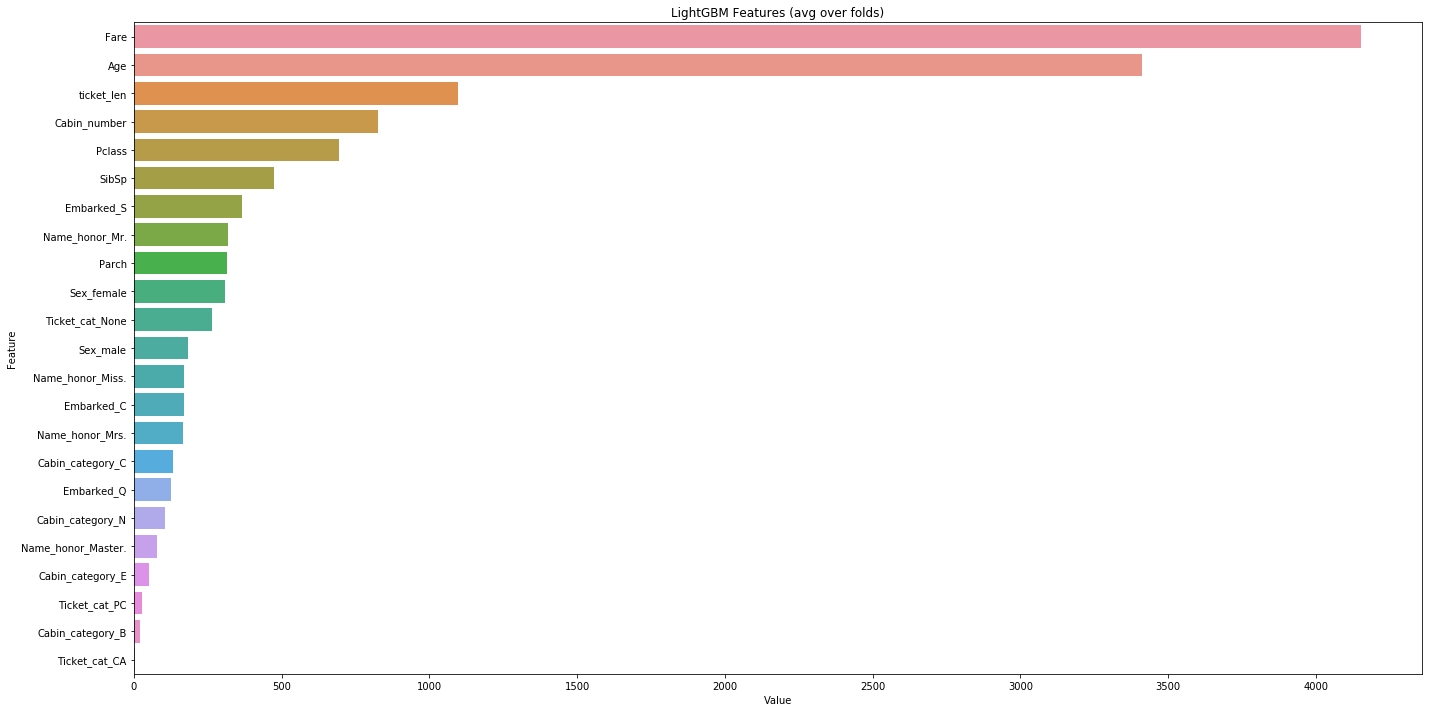

In [24]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.loc[feature_imp['Value'] > 0].sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [25]:
top_feats = feature_imp.loc[feature_imp['Value'] > 0].Feature.values.tolist()

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(features[top_feats], train['Survived'], test_size=0.2, random_state=42)

## Model Benchmarking

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

### Logistic

In [28]:
lr = LogisticRegression(solver='lbfgs',
                       multi_class = 'ovr',
                       n_jobs = -1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

AUC Score: 0.874958
Recall Score: 0.764925
F1 Score: 0.779468


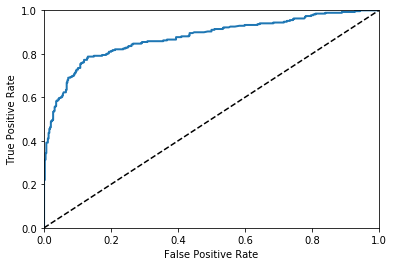

In [31]:
print("AUC Score: %f" % roc_auc_score(y_train, lr.predict_proba(X_train)[:,1]))
print("Recall Score: %f" %recall_score(y_train, lr.predict(X_train)))
print("F1 Score: %f" % f1_score(y_train, lr.predict(X_train)))
fpr, tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train)[:,1])
plot_roc_curve(fpr, tpr)
plt.show()

### Random Forest

In [33]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [34]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

AUC Score: 0.854465
Recall Score: 0.682836
F1 Score: 0.709302


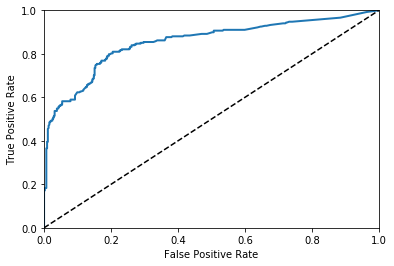

In [35]:
print("AUC Score: %f" % roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1]))
print("Recall Score: %f" %recall_score(y_train, rfc.predict(X_train)))
print("F1 Score: %f" % f1_score(y_train, rfc.predict(X_train)))
fpr, tpr, thresholds = roc_curve(y_train, rfc.predict_proba(X_train)[:,1])
plot_roc_curve(fpr, tpr)
plt.show()

### XGBoost

In [36]:
xgbc = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     n_jobs = -1,
     scale_pos_weight=scale_pos_weight_val,
     silent = True,
     seed=27)

In [37]:
xgbc.fit(X_train, y_train, 
         eval_metric = 'auc',
         eval_set = [(X_valid, y_valid)],
         early_stopping_rounds = 500)

[0]	validation_0-auc:0.847941
Will train until validation_0-auc hasn't improved in 500 rounds.
[1]	validation_0-auc:0.849421
[2]	validation_0-auc:0.863642
[3]	validation_0-auc:0.863964
[4]	validation_0-auc:0.863063
[5]	validation_0-auc:0.864414
[6]	validation_0-auc:0.873423
[7]	validation_0-auc:0.870399
[8]	validation_0-auc:0.868468
[9]	validation_0-auc:0.867053
[10]	validation_0-auc:0.877542
[11]	validation_0-auc:0.877027
[12]	validation_0-auc:0.880245
[13]	validation_0-auc:0.881145
[14]	validation_0-auc:0.879151
[15]	validation_0-auc:0.880566
[16]	validation_0-auc:0.88121
[17]	validation_0-auc:0.880824
[18]	validation_0-auc:0.880116
[19]	validation_0-auc:0.880245
[20]	validation_0-auc:0.876705
[21]	validation_0-auc:0.87529
[22]	validation_0-auc:0.867181
[23]	validation_0-auc:0.867439
[24]	validation_0-auc:0.869112
[25]	validation_0-auc:0.871943
[26]	validation_0-auc:0.876898
[27]	validation_0-auc:0.87677
[28]	validation_0-auc:0.87677
[29]	validation_0-auc:0.875611
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8, verbosity=1)

AUC Score: 0.980604
Recall Score: 0.876866
F1 Score: 0.910853


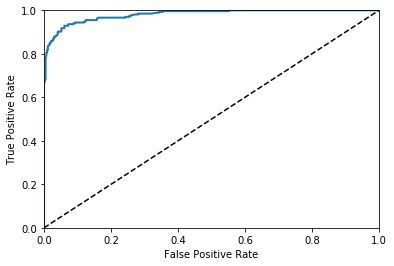

In [38]:
print("AUC Score: %f" % roc_auc_score(y_train, xgbc.predict_proba(X_train)[:,1]))
print("Recall Score: %f" %recall_score(y_train, xgbc.predict(X_train)))
print("F1 Score: %f" % f1_score(y_train, xgbc.predict(X_train)))
fpr, tpr, thresholds = roc_curve(y_train, xgbc.predict_proba(X_train)[:,1])
plot_roc_curve(fpr, tpr)
plt.show()

### Comparison

In [39]:
def cross_validate(model, features, label, n_cv, scoring):
    scores = cross_val_score(model, features, label,
                             scoring=scoring, cv=n_cv)
    
    return scores

In [40]:
def model_benchmark(models, X_test, y_test, n_cv, scoring):
    performance_benchmark = pd.DataFrame(columns=['model',scoring])
    for model in models:
        temp_model = [model]*n_cv
        temp_performance = cross_validate(models[model], X_test, y_test, n_cv, scoring)
        temp_df = pd.DataFrame({'model': temp_model, scoring: temp_performance})
        performance_benchmark = pd.merge(performance_benchmark, temp_df, how = 'outer')
    sns.boxplot(x="model", y=scoring, data=performance_benchmark)
    plt.title('Performance Benchmark')

In [41]:
models = {'logistic' : lr, 'random forest': rfc, 'xgboost': xgbc}

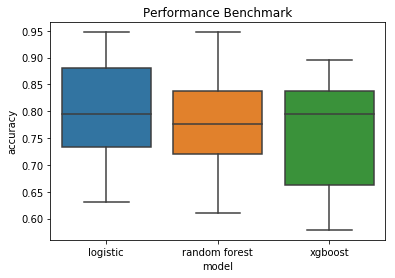

In [42]:
model_benchmark(models, X_valid, y_valid, 10, 'accuracy')

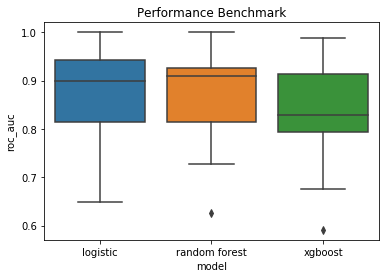

In [43]:
model_benchmark(models, X_valid, y_valid, 10, 'roc_auc')

## Export Model

In [44]:
import joblib

In [45]:
joblib.dump(lr, 'logisticreg.pkl')
joblib.dump(rfc, 'randomforestclassifier.pkl')
joblib.dump(xgbc, 'xgbclassifier.pkl')

['xgbclassifier.pkl']

## Test

In [46]:
def predict_export_csv(model, feature, index, file_name):
    temp_output = model.predict(feature)
    temp_output_df = pd.DataFrame({'PassengerId': index, 'Survived': temp_output })
    temp_output_df.to_csv('{}.csv'.format(file_name), sep=',', encoding='utf-8', index=False)

In [48]:
test = add_feature(test)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
test['Cabin'].fillna('None', inplace = True)

In [57]:
for num_col in [x for x in num_cols if x not in ['Survived']]:
    if test[num_col].isnull().values.any():
        print('imputing for {}'.format(num_col))
        test[num_col] = imp_median.fit_transform(test[num_col].values.reshape(-1,1)) 

imputing for Age
imputing for Fare


In [58]:
test_processed = test.copy()
for skew_col in skew_cols:
    test_processed[skew_col] = log_transform(test_processed, skew_col)

In [59]:
test_processed_features = pd.get_dummies(test_processed)

In [60]:
test_processed_features = test_processed_features[top_feats]

In [61]:
predict_export_csv(xgbc, test_processed_features, test['PassengerId'], 'xgb_classifier1')

In [62]:
predict_export_csv(lr, test_processed_features, test['PassengerId'], 'lr_classifier1')

In [63]:
predict_export_csv(rfc, test_processed_features, test['PassengerId'], 'rfc_classifier1')